<a href="https://colab.research.google.com/github/jinyang628/cs4248/blob/basic-pipeline/CS4248.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import kagglehub
import os
import shutil
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
# Load Kaggle dataset
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")
print("Kaggle dataset available at:", path)

Kaggle dataset available at: /root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9


In [46]:
train_csv_path = os.path.join(path, 'train.csv')
df = pd.read_csv(train_csv_path, encoding='latin1')

display(df.head())

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [47]:
# Drop the columns that are probably unrelated to the setiment
df.drop(["Population -2020", "Land Area (Km²)", "Density (P/Km²)"], axis=1, inplace=True)
display(df.head())

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola


In [48]:
# Drop rows that have missing values in crucial columms
df.dropna(subset=['text', 'sentiment'], inplace=True)

In [49]:
MAX_FEATURES = 5000
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # smaller vocab space, probably fine because ALL CAPS is merely an amplifier and doesn't flip classification (TODO: Remove and verify)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters and punctuation for smaller vocab space. But random special characters !@&^#^&$#^$ might imply rage/negative sentiment (TODO: Remove and verify)
    text = re.sub(r'\d+', '', text) # Remove numbers (But it can affect sentiment . E.g. I have 100000 pieces of hw to do vs I won 1000000 dollars) so might want to keep it and when combined with other words, affect classification (TODO: Remove and verify)
    tokens = text.split()
    cleaned_tokens = [word for word in tokens if word not in stop_words] # TODO: Remove only the subset of stopwords unrelated to sentiment
    return ' '.join(cleaned_tokens)

X_cleaned = df["text"].apply(preprocess_text)

tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
X_vectorized = tfidf_vectorizer.fit_transform(X_cleaned)


y = df["sentiment"]

In [50]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (21984, 5000)
Shape of X_test: (5496, 5000)
Shape of y_train: (21984,)
Shape of y_test: (5496,)


In [56]:
MAX_ITERATIONS = 100
model = LogisticRegression(max_iter=MAX_ITERATIONS)
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


In [57]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.6861

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.57      0.63      1572
     neutral       0.62      0.75      0.68      2236
    positive       0.77      0.70      0.74      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.68      5496
weighted avg       0.70      0.69      0.69      5496



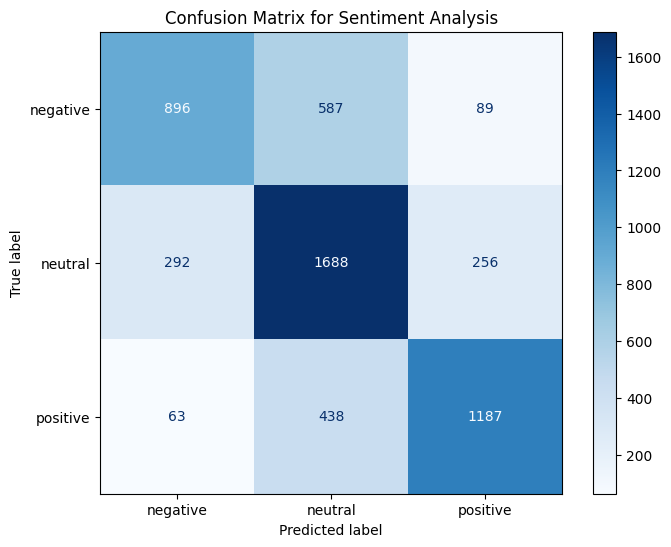

In [58]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(8, 6)) # Adjust figure size for better readability
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Sentiment Analysis')

plt.show()